# splitting data into 4 stages

This is a remake of the stages.ipynb which is splitting data into 3 stages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

# n grams
from sklearn.feature_extraction.text import CountVectorizer

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1
# raw.head()

all_splits = pd.to_datetime(['2020-03-05', '2020-03-26', '2020-05-01'])
raw['stage'] = ['s:1' if date < all_splits[0] else 's:2' if date < all_splits[1] else 's:3' if date < all_splits[2] else 's:4' for date in raw['date']]



#########################
# thresholds
thresholds = [0.8, 0.9, 0.95]
for thresh in thresholds:
    raw[f't:{thresh}'] = [1 if float(conf) > thresh else 0 for conf in raw['sent_confidence']]

col = 't:0.8'
raw['category'] = ['NEUT' if t == 0 else 'POS' if p == 1 else 'NEG' for i, n, p, t in raw[['is_negative', 'is_positive', col]].itertuples()]
raw['is_neutral'] = [1 if cat == 'NEUT' else 0 for cat in raw['category']]
raw['is_positive'] = [1 if cat == 'POS' else 0 for cat in raw['category']]
raw['is_negative'] = [1 if cat == 'NEG' else 0 for cat in raw['category']]

raw['is_neutral2'] = raw['is_neutral']
raw['is_positive2'] = raw['is_positive']
raw['is_negative2'] = raw['is_negative']

raw['is_neutral3'] = raw['is_neutral']
raw['is_positive3'] = raw['is_positive']
raw['is_negative3'] = raw['is_negative']

##################
# cdc

keywords = ['social distancing', 'social distance', 'physical distance', '6 feet', 'stay at home', 'school isolation', 'isolation', 'stay home', 'avoid touching', 'mask', 'covering', 'face shield', 'wear a mask', 'surgical mask', 'N95 respirator', 'wearing gloves', 'face shields', 'facial covering', 'skin protection', 'eye protection', 'ppe', 'wash hands', 'hand sanitizer', 'disinfect', 'clean', 'detergent', 'handwashing', 'hand hygiene', 'prevention hygiene', 'sprays', 'concentrates', 'wipes', 'routine cleaning', 'bleach solution', 'test', 'business closure']

topics = []
indexes = {i:0 for i in range(len(raw.index))}

for i, topic in enumerate(keywords):
    topics.append([1 if topic in text else 0 for text in raw['ogtext']])

for i, kw in enumerate(topics):
    for data_ind, value in enumerate(topics[i]):
        indexes[data_ind] += value

raw['in_cdc'] = [indexes[i] if 0 <= indexes[i] <= 1 else 1 for i in indexes]

cdc = raw[raw['in_cdc'] == 1]

cdc_splits = pd.to_datetime(['2020-03-12', '2020-04-20', '2020-05-14'])
cdc['stage'] = ['s:1' if date < cdc_splits[0] else 's:2' if date < cdc_splits[1] else 's:3' if date < cdc_splits[2] else 's:4' for date in cdc['date']]

# print(f'there are a total of {len(cdc.index)} tweets after subsetting for cdc keywords')
# print(raw)
# print(cdc)
print('loaded...')

loaded...
<ipython-input-1-b4d858f5a9bd>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdc['stage'] = ['s:1' if date < cdc_splits[0] else 's:2' if date < cdc_splits[1] else 's:3' if date < cdc_splits[2] else 's:4' for date in cdc['date']]


# eyeballing 4 possible splits
Splits based off lingzi suggestion dates
beggining - 03/05, 03/06 - 03/25, 03/26 - 05/20, 05/21 - end

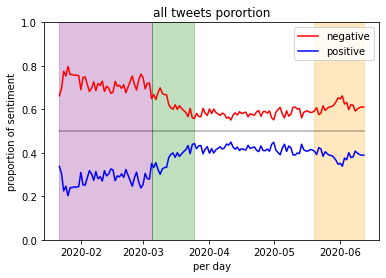

In [2]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4)) #sharey = True

ndf = raw.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
ndf['nnegative'] = ndf['count'] * ndf['is_negative']
ndf['npositive'] = ndf['count'] - ndf['nnegative']
ndf['is_positive'] = 1 - ndf['is_negative']
# sum = ndf['count'].sum()
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

splits = pd.to_datetime(['2020-03-05', '2020-03-25', '2020-05-20'])
colors = ['purple', 'green', 'orange', 'black']
# print(min_date)

ax.plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
ax.plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
ax.plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
for i, split in enumerate(splits):
    if i == 0:
        ax.axvspan(min_date, split, 0, 1, alpha=0.25, color=colors[0])
        last = split
    if i != len(splits)-1:
        ax.axvspan(last, split, 0, 1, alpha=0.25, color=colors[1])
        last = split
    if i == len(splits)-1:
        ax.axvspan(split, max_date, 0, 1, alpha=0.25, color=colors[2])
ax.set_ylabel('proportion of sentiment')
ax.set_xlabel('per day')
ax.set_title(f'all tweets porortion')
ax.set_ylim(0,1)
ax.legend()
plt.show()

# finding important events around these dates

near first decline:

+ march 1-2
    - In New York, Governor Andrew Cuomo announces the state's first reported case of COVID-19

+ march 3
    - The CDC lifted federal restrictions on coronavirus testing to allow any American to be tested for coronavirus, “subject to doctor’s orders.”[107]
        + good choice as it involved the CDC ***

+ march 4
    - In California, Governor Gavin Newsom declares a state of emergency.[109]
        + first state of emergency declared *** good choice

+ march 5
    - Ten states report their first case of coronavirus: Hawaii, Utah, Nebraska, Kentucky, Indiana, Minnesota, Connecticut, South Carolina, Pennsylvania, and Oklahoma.
        + also good choice as many states are starting to see cases across US ****

+ march 7-9
    - 6 states report first cases
    - 19 deaths has been reached
    - more state of emergencies are declared

+ march 13
    - President Trump declared a national emergency.
        + great choice, but doesnt fit with 4 stage split
        + this was date that was chosen with 3 stage split ***

near end of decline:

+ march 24
    - Three U.S. Army hospital units were deployed to New York and Washington State. [384] The Army Corps of Engineers and the National Guard have under construction four hospitals and four medical centers in New York.[385] FEMA sent New York 2,000 ventilators. [386]
    - many states confirmed cases are rising

+ march 25
    - Senate Republicans and Democrats strike a deal on a version of the stimulus bill
        + great choice here ***

+ march 26
    - United States: the total number of reported confirmed cases in the United States surpasses that of China with over 85,000, making it the country with the highest number of coronavirus patients, in the world.[392][393][394]

+ march 27
    - President Trump signs the Coronavirus Aid, Relief, and Economic Security Act into law on March 27.[citation needed]
        + also a good choice, but slightly into the upward trend


near end of stability:

+ may 1 ish
    - a few executive orders, smaller protests (among many), plans for getting 'back on track'
        + nothing good here event wise

+ may 26
    - The George Floyd protests begin in Minneapolis.[500]
        + good choice as well

+ may 27
    - The number of COVID-19 deaths in the U.S. tops 100,000.[509]
        + this was date chosen with 3 stage split ***
        + bleeds into uphill climb slightly

+ may 31
    - As of May 31, Our World in Data reported that for the U.S. there were 103,781 total deaths, 1.77 million confirmed cases, and about 14 million tests completed.[510]


# drawing a line at each possible good choice listed

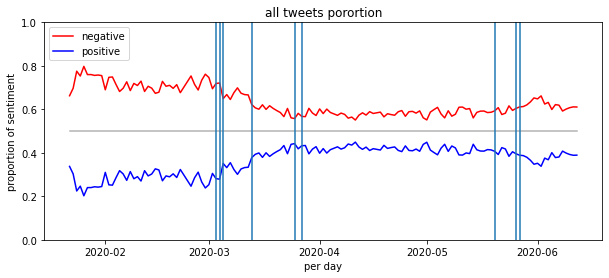

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4)) #sharey = True

ndf = raw.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
ndf['nnegative'] = ndf['count'] * ndf['is_negative']
ndf['npositive'] = ndf['count'] - ndf['nnegative']
ndf['is_positive'] = 1 - ndf['is_negative']
# sum = ndf['count'].sum()
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

choices = pd.to_datetime(['2020-03-03', '2020-03-04', '2020-03-05', '2020-03-13', '2020-03-25', '2020-03-27', '2020-05-20', '2020-05-26', '2020-05-27'])
colors = ['purple', 'green', 'orange', 'black']
# print(min_date)

ax.plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
ax.plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
ax.plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
for choice in choices:
    ax.axvline(x=choice)
ax.set_ylabel('proportion of sentiment')
ax.set_xlabel('per day')
ax.set_title(f'all tweets porortion')
ax.set_ylim(0,1)
ax.legend()
plt.show()

# splitting 4 stages by math

finding best fit lines all close to 0

(14, 45, 134, 0.0007177926473646463, -0.00012944004629105165, -3.051555596884867e-05, 3.090552559115167e-05, 0.0009086537752156984)
splits are at 2020-02-05, 2020-03-08, 2020-06-05


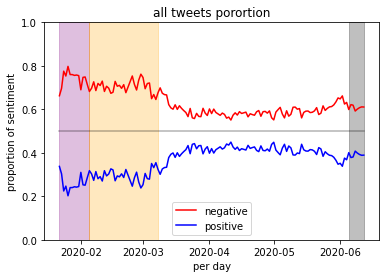

In [8]:
x_y_dict = {x:y for x,y in enumerate(raw.groupby(['date']).agg({'is_negative':'mean'})['is_negative'])}
date2i = {i:date for i,date in enumerate(raw.groupby(['date']).agg({'is_negative':'mean'}).index)}
X = [x for x in x_y_dict]
Y = [x_y_dict[x] for x in x_y_dict]

def best_fit(X, Y):
    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    return b
# import math as m
keep = None

for a in range(3, len(X)-2): # 3 to 139
    for b in range(4, len(X)-3):
        for c in range(4, len(X)-3):
            if a < b and b - a > 3 and c - b > 3: # splits are concurrent and the middle section is at least 3
                X1, X2, X3, X4 = X[0:a], X[a:b], X[b:c], X[c:]
                Y1, Y2, Y3, Y4 = Y[0:a], Y[a:b], Y[b:c], Y[c:]
                if len(X1) > 3 and len(X2) > 3 and len(X3) > 3 and len(X4) > 3: # min length of stages?
                    s1, s2, s3, s4 = best_fit(X1, Y1), best_fit(X2, Y2), best_fit(X3, Y3), best_fit(X4, Y4)
                    ss = abs(s1) + abs(s2) + abs(s3) + abs(s4)
                    # if sum of slopes is closer to 0, then keep
                    if keep is None or ss < keep[-1]:
                        keep = (a, b, c, s1, s2, s3, s4, ss)
                

print(keep)
print(f'splits are at {date2i[keep[0]]}, {date2i[keep[1]]}, {date2i[keep[2]]}')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4)) #sharey = True

ndf = raw.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
ndf['nnegative'] = ndf['count'] * ndf['is_negative']
ndf['npositive'] = ndf['count'] - ndf['nnegative']
ndf['is_positive'] = 1 - ndf['is_negative']
# sum = ndf['count'].sum()
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

splits = [date2i[keep[0]], date2i[keep[1]], date2i[keep[2]]]
colors = ['purple', 'orange', 'black']
# print(min_date)

ax.plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
ax.plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
ax.plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
for i, split in enumerate(splits):
    if i == 0:
        ax.axvspan(min_date, split, 0, 1, alpha=0.25, color=colors[0])
        last = split
    if i != len(splits)-1:
        ax.axvspan(last, split, 0, 1, alpha=0.25, color=colors[1])
        last = split
    if i == len(splits)-1:
        ax.axvspan(split, max_date, 0, 1, alpha=0.25, color=colors[2])
ax.set_ylabel('proportion of sentiment')
ax.set_xlabel('per day')
ax.set_title(f'all tweets porortion')
ax.set_ylim(0,1)
ax.legend()
plt.show()


not at all what we want, lets try changing the requirements

# another method of math

we only want the stage 1 and stage 3 to be as close to 0 as possible

this naturally leaves stage 2 to decline and stage 4 to incline


(42, 65, 97, 0.0015964432229034692)
splits are at 2020-03-05, 2020-03-28, 2020-04-29


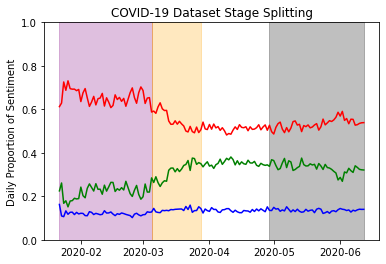

In [11]:
# negative
x_y_dict = {x:y for x,y in enumerate(raw.groupby(['date']).agg({'is_negative':'mean'})['is_negative'])}
date2i = {i:date for i,date in enumerate(raw.groupby(['date']).agg({'is_negative':'mean'}).index)}
Xneg = [x for x in x_y_dict]
Yneg = [x_y_dict[x] for x in x_y_dict]

x_y_dict = {x:y for x,y in enumerate(raw.groupby(['date']).agg({'is_positive':'mean'})['is_positive'])}
# date2i = {i:date for i,date in enumerate(raw.groupby(['date']).agg({'is_positive':'mean'}).index)}
Xpos = [x for x in x_y_dict]
Ypos = [x_y_dict[x] for x in x_y_dict]

x_y_dict = {x:y for x,y in enumerate(raw.groupby(['date']).agg({'is_neutral':'mean'})['is_neutral'])}
# date2i = {i:date for i,date in enumerate(raw.groupby(['date']).agg({'is_neutral':'mean'}).index)}
Xneut = [x for x in x_y_dict]
Yneut = [x_y_dict[x] for x in x_y_dict]

def best_fit(X, Y):
    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    return b
# import math as m
keep = None

for a in range(3, len(Xneg)-9): # 3 to 139
    for b in range(6, len(Xneg)-6): # 6 to 138
        for c in range(9, len(Xneg)-3): # 9 to 137
            if a < b < c: # splits are concurrent
                X1neg, X2neg, X3neg, X4neg = Xneg[0:a], Xneg[a:b], Xneg[b:c], Xneg[c:]
                Y1neg, Y2neg, Y3neg, Y4neg = Yneg[0:a], Yneg[a:b], Yneg[b:c], Yneg[c:]

                X1pos, X2pos, X3pos, X4pos = Xpos[0:a], Xpos[a:b], Xpos[b:c], Xpos[c:]
                Y1pos, Y2pos, Y3pos, Y4pos = Ypos[0:a], Ypos[a:b], Ypos[b:c], Ypos[c:]

                X1neut, X2neut, X3neut, X4neut = Xneut[0:a], Xneut[a:b], Xneut[b:c], Xneut[c:]
                Y1neut, Y2neut, Y3neut, Y4neut = Yneut[0:a], Yneut[a:b], Yneut[b:c], Yneut[c:]

                if len(X1neg) >= 3 and len(X2neg) >= 3 and len(X3neg) >= 3 and len(X4neg) >= 3: # min length of stages?

                    s1neg, s2neg, s3neg, s4neg = best_fit(X1neg, Y1neg), best_fit(X2neg, Y2neg), best_fit(X3neg, Y3neg), best_fit(X4neg, Y4neg)
                    s1pos, s2pos, s3pos, s4pos = best_fit(X1pos, Y1pos), best_fit(X2pos, Y2pos), best_fit(X3pos, Y3pos), best_fit(X4pos, Y4pos)
                    s1neut, s2neut, s3neut, s4neut = best_fit(X1neut, Y1neut), best_fit(X2neut, Y2neut), best_fit(X3neut, Y3neut), best_fit(X4neut, Y4neut)

                    val2min = abs(s1neg) + abs(s3neg) + abs(s1pos) + abs(s3pos) + abs(s1neut) + abs(s3neut)
                    if keep is None:
                        keep = (a, b, c, val2min)
                    elif val2min < abs(keep[3]):
                        keep = (a, b, c, val2min)
                

print(keep)
print(f'splits are at {date2i[keep[0]]}, {date2i[keep[1]]}, {date2i[keep[2]]}')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4)) #sharey = True

ndf = raw.groupby(['date']).agg({'count':'count', 'is_negative':'mean', 'is_negative2':'sum', 'is_positive':'mean', 'is_positive2':'sum', 'is_neutral':'mean', 'is_neutral2':'sum'}).reset_index()
ndf['nnegative'] = ndf['is_negative2']
ndf['npositive'] = ndf['is_positive2']
ndf['nneutral'] = ndf['is_neutral2']
# sum = ndf['count'].sum()
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

splits = [date2i[keep[0]], date2i[keep[1]], date2i[keep[2]]]
colors = ['purple', 'orange', 'black']
# print(min_date)

ax.plot(ndf['date'], ndf.is_negative, color= 'r', label='Negative')
ax.plot(ndf['date'], ndf.is_positive, color = 'g', label='Positive')
ax.plot(ndf['date'], ndf.is_neutral, color = 'b', label='Neutral')
# ax.plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
for i, split in enumerate(splits):
    if i == 0:
        ax.axvspan(min_date, split, 0, 1, alpha=0.25, color=colors[0])
        last = split
    if i != len(splits)-1:
        ax.axvspan(last, split, 0, 1, alpha=0.25, color=colors[1])
        last = split
    if i == len(splits)-1:
        ax.axvspan(split, max_date, 0, 1, alpha=0.25, color=colors[2])
ax.set_ylabel('Daily Proportion of Sentiment')
ax.set_title(f'COVID-19 Dataset Stage Splitting')
ax.set_ylim(0,1)
# ax.legend()
plt.show()
